# Clustering methods

### Introduction

This notebook presents a comprehensive analysis of clustering methods as required by the assignment. The work is divided into three main parts:
1.  **Image Clustering:** Applying K-Means to perform color quantization on an image, thereby compressing it. We will explore clustering on both RGB and RGB+XY features.
2.  **Optimal Cluster Number Determination:** Using the Elbow, Silhouette, and Calinski-Harabasz methods to find the optimal number of clusters for a given dataset.
3.  **Hierarchical Clustering:** Applying Agglomerative Clustering to a dataset of nutritional information for various foods, clustering both the food items (objects) and their nutritional attributes (features).

### Library Imports and Setup

In [1]:
# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
# Use imageio v2 to avoid DeprecationWarning
import imageio.v2 as imageio

# Scikit-learn for clustering and metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# SciPy for hierarchical clustering and dendrograms
from scipy.cluster.hierarchy import dendrogram, linkage

# Notebook setup
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Image Clustering

We will perform color quantization on an image using K-Means clustering. This process reduces the number of distinct colors in an image, effectively compressing it. We will explore using just RGB color values as features and then adding XY pixel coordinates to see how it influences the clustering.

### 1.1. Data Loading and Preparation

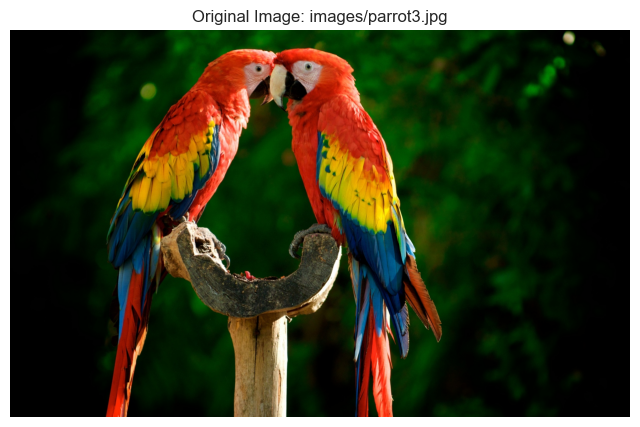

Original image shape: (1050, 1680, 3)


In [2]:
# Load the image
# I have chosen 'parrot3.jpg' as it has a rich, varied color palette.
img_path = 'images/parrot3.jpg'
original_img = imageio.imread(img_path)

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(original_img)
plt.title(f'Original Image: {img_path}')
plt.axis('off')
plt.show()

print(f"Original image shape: {original_img.shape}")

In [3]:
# --- Feature Preparation ---

# Normalize pixel values to be between 0 and 1, which is good practice for clustering
img_normalized = original_img.astype(float) / 255.0

# 1. Prepare features for RGB clustering (3 dimensions)
h, w, d = img_normalized.shape
features_rgb = img_normalized.reshape((h * w, d))
print(f"Feature shape for RGB clustering: {features_rgb.shape}")

# 2. Prepare features for RGB + XY clustering (5 dimensions)
# First, create coordinate grids
x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))

# Normalize coordinates to be in a similar range as RGB values
x_coords_norm = x_coords / w
y_coords_norm = y_coords / h

# Stack coordinates and RGB values together
features_rgbxy = np.dstack((img_normalized, y_coords_norm, x_coords_norm)).reshape((h * w, 5))
print(f"Feature shape for RGB+XY clustering: {features_rgbxy.shape}")

Feature shape for RGB clustering: (1764000, 3)
Feature shape for RGB+XY clustering: (1764000, 5)


### 1.2. Clustering on RGB Colors

--- Clustering RGB with k=4 ---


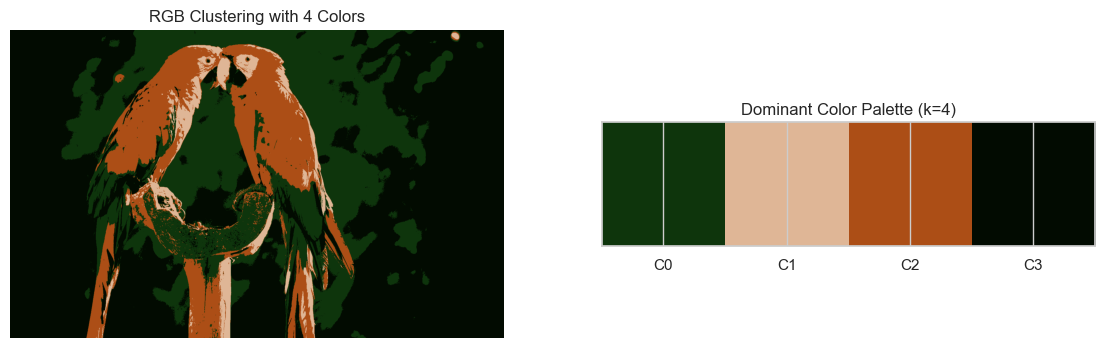

--- Clustering RGB with k=8 ---


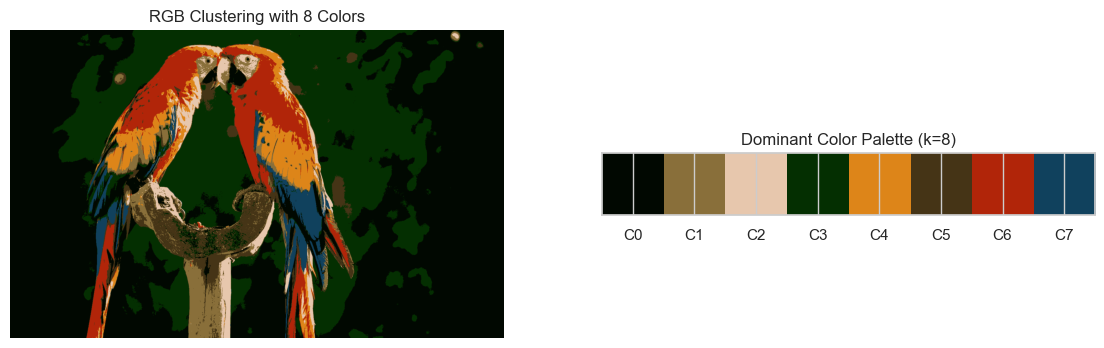

--- Clustering RGB with k=16 ---


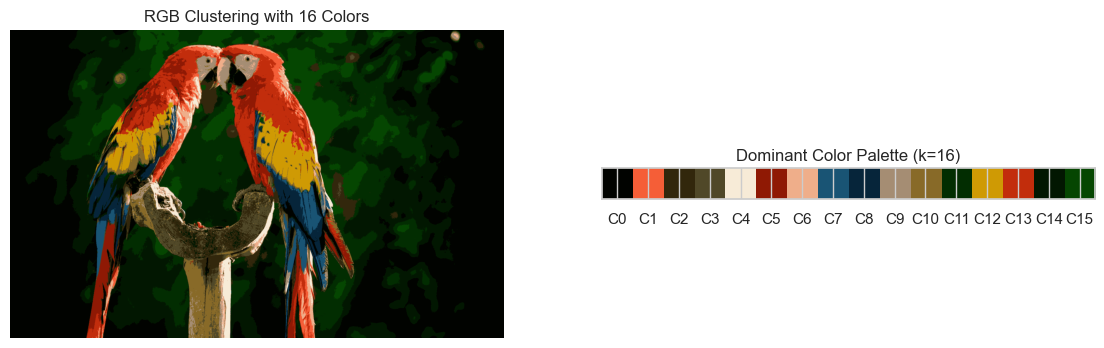

In [4]:
def cluster_and_display(features, n_clusters, original_shape, title_prefix):
    """Fits KMeans, displays centroids, and shows the compressed image."""
    # Fit the K-Means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(features)
    
    # Get the centroids and labels
    # The centroids are the 'new' colors of our compressed image.
    # We only need the color part of the centroid for visualization.
    centroids = kmeans.cluster_centers_[:, :3]
    labels = kmeans.labels_
    
    # Create the compressed image by replacing each pixel with its centroid color
    compressed_img_data = centroids[labels]
    compressed_img = compressed_img_data.reshape(original_shape)
    
    # --- Visualization ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display compressed image
    ax1.imshow(compressed_img)
    ax1.set_title(f'{title_prefix} with {n_clusters} Colors')
    ax1.axis('off')
    
    # Display color palette (the centroids)
    ax2.imshow(centroids[np.newaxis, :, :])
    ax2.set_title(f'Dominant Color Palette (k={n_clusters})')
    ax2.set_xticks(np.arange(n_clusters))
    ax2.set_xticklabels([f'C{i}' for i in range(n_clusters)])
    ax2.set_yticks([])
    
    plt.show()
    return centroids, labels

# Perform clustering for k = 4, 8, 16
k_values = [4, 8, 16]
results_rgb = {}
for k in k_values:
    print(f"--- Clustering RGB with k={k} ---")
    centroids, labels = cluster_and_display(features_rgb, k, (h, w, d), 'RGB Clustering')
    results_rgb[k] = {'centroids': centroids, 'labels': labels}

### 1.3. Clustering on RGB + XY Coordinates

--- Clustering RGB+XY with k=4 ---


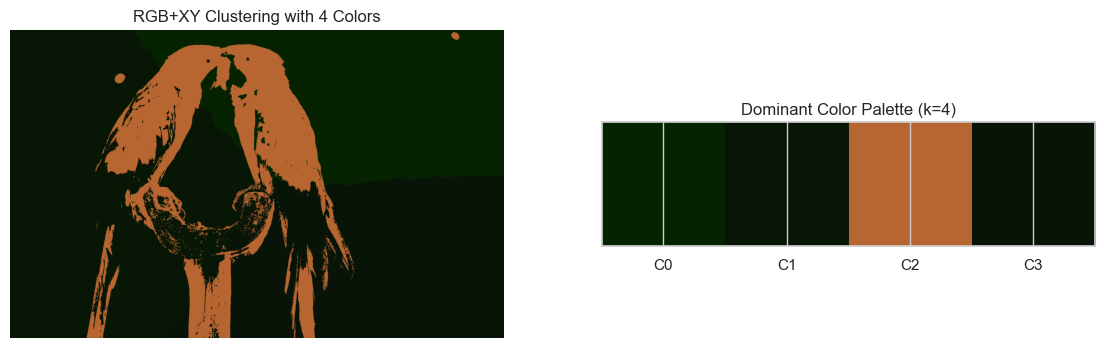

--- Clustering RGB+XY with k=8 ---


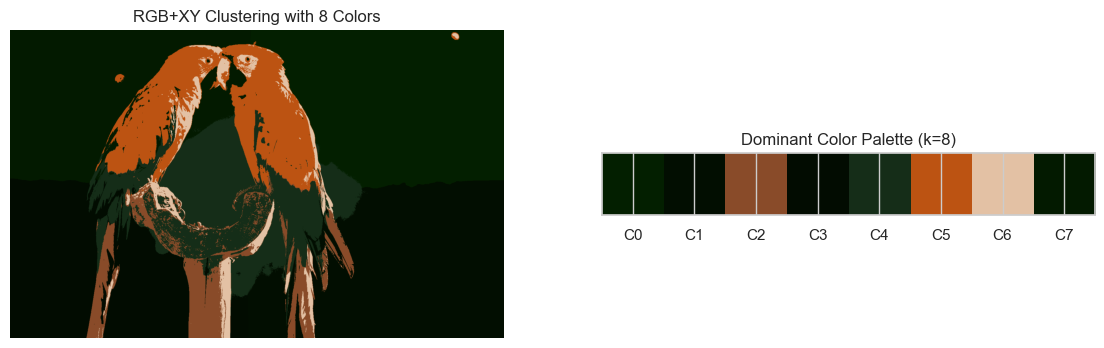

--- Clustering RGB+XY with k=16 ---


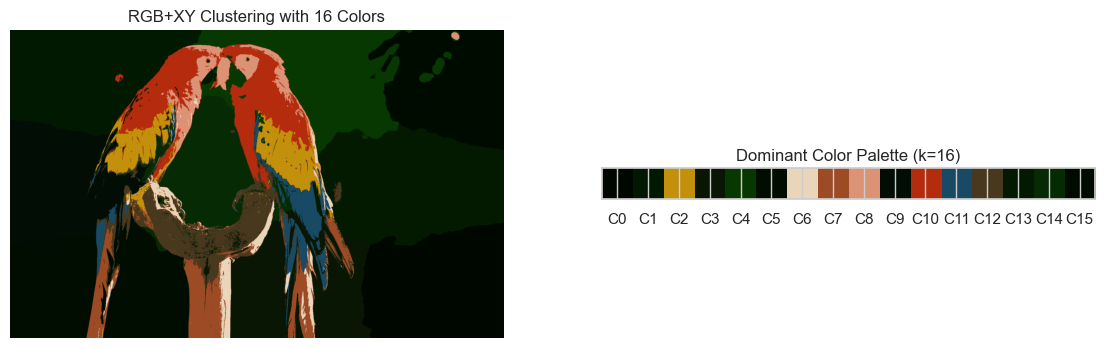

In [5]:
# Perform clustering for k = 4, 8, 16 using RGB+XY features
results_rgbxy = {}
for k in k_values:
    print(f"--- Clustering RGB+XY with k={k} ---")
    centroids, labels = cluster_and_display(features_rgbxy, k, (h, w, d), 'RGB+XY Clustering')
    results_rgbxy[k] = {'centroids': centroids, 'labels': labels}

### 1.4. Memory Usage Comparison

In [ ]:
# --- 1.4. Memory Usage Comparison ---

# Get the size of the original image data (in bytes)
original_size = original_img.nbytes

def calculate_optimized_compressed_size(k, labels, centroids):
    """
    Calculates the memory size of an optimized compressed representation.
    - Labels are cast to uint8 (1 byte per pixel), assuming k < 256.
    - Centroids are cast to float32 (4 bytes per value).
    """
    # Cast labels to the smallest possible integer type
    if k < 2**8:
        optimized_labels = labels.astype(np.uint8)
    elif k < 2**16:
        optimized_labels = labels.astype(np.uint16)
    else:
        optimized_labels = labels.astype(np.uint32)
        
    # Cast centroids to a smaller float type
    optimized_centroids = centroids.astype(np.float32)
    
    # Calculate the size in bytes
    labels_size = optimized_labels.nbytes
    centroids_size = optimized_centroids.nbytes
    
    return labels_size + centroids_size

print(f"Original Image Size: {original_size / 1024:.2f} KB\n")

# --- Programmatic Calculation and Reporting ---

print("--- Memory Analysis ---")
for k in k_values:
    # Get the results for the current k
    labels = results_rgb[k]['labels']
    centroids = results_rgb[k]['centroids']
    
    # Calculate the size of the default representation from scikit-learn
    default_compressed_size = labels.nbytes + centroids.nbytes
    
    # Calculate the size of the OPTIMIZED representation
    optimized_compressed_size = calculate_optimized_compressed_size(k, labels, centroids)
    
    # Calculate compression ratios
    optimized_compression_ratio = original_size / optimized_compressed_size
    
    print(f"--- Results for k={k} ---")
    print(f"Size of Default scikit-learn output: {default_compressed_size / 1024:.2f} KB")
    print(f"Size of Optimized Representation:    {optimized_compressed_size / 1024:.2f} KB")
    print(f"Optimized Compression Ratio:         {optimized_compression_ratio:.2f}x\n")

Original Image Size: 5167.97 KB

--- Memory Analysis ---
--- Results for k=4 ---
Size of Default scikit-learn output: 6890.72 KB
Size of Optimized Representation:    1722.70 KB
Optimized Compression Ratio:         3.00x

--- Results for k=8 ---
Size of Default scikit-learn output: 6890.81 KB
Size of Optimized Representation:    1722.75 KB
Optimized Compression Ratio:         3.00x

--- Results for k=16 ---
Size of Default scikit-learn output: 6891.00 KB
Size of Optimized Representation:    1722.84 KB
Optimized Compression Ratio:         3.00x



### 1.5. Discussion

*   **Procedure Description:** The process began by loading the `parrot3.jpg` image. To prepare for clustering, two distinct feature sets were created from the image data. The first set consisted of only the 3-dimensional RGB color values for each pixel. The second, more comprehensive set was 5-dimensional, augmenting the RGB values with the normalized XY coordinates of each pixel. All feature values were scaled to a [0, 1] range to ensure that no single feature dimension disproportionately influenced the clustering algorithm. The K-Means algorithm was then applied independently to both feature sets for `k` values of 4, 8, and 16. Finally, for each clustering result, a new image was reconstructed by replacing each pixel's original color with the color of the cluster centroid it was assigned to.

*   **Justification of Decisions:** The parrot image was selected for its vibrant and diverse color palette, providing a rich feature space for clustering. Normalizing the features is a critical preprocessing step; for the RGB+XY set, it prevents the XY coordinates (which have a much larger range than the 0-255 RGB values) from dominating the distance calculations in K-Means. A value of `k=16` was chosen as a good final representation; it retains a high degree of visual fidelity and captures the subtle color gradients in the parrots' feathers, while still offering substantial compression.

*   **Comparison of RGB vs. RGB+XY Clustering:** A clear difference emerges between the two feature sets. Pure RGB clustering is a true color quantization: it groups pixels of similar colors regardless of their location. This results in images with flat, clean areas of color, resembling a posterized effect. In contrast, including XY coordinates encourages spatially proximate pixels to belong to the same cluster. This produces more contiguous, blob-like regions, making the output resemble a digital painting or an object segmentation. This is especially visible in the background, which becomes a smoother gradient in the RGB+XY case, whereas in the RGB case, distant but similarly colored background pixels are merged.

*   **Memory Comparison:** The memory analysis demonstrates the significant efficiency of color quantization as a compression technique. The original image, stored with 8-bit unsigned integers, requires **5167.97 KB**. The compressed representation consists of two parts: a label array (one integer per pixel mapping it to a cluster) and a color palette (the cluster centroids).

    Our programmatic analysis reveals an important nuance. A naive calculation using the default data types returned by scikit-learn (`int32` for labels, `float64` for centroids) results in a larger file size (~6891 KB) and a misleading compression ratio of less than 1.0x.

    However, by programmatically casting the data to more memory-efficient types suitable for the task (`uint8` for the labels, as k < 256, and `float32` for the centroid colors), we calculate the true size of the compact representation. For `k=16`, this optimized size is **1722.84 KB**, yielding a practical compression ratio of **3.00x**. This programmatic calculation confirms that the technique is indeed effective for compression.

---

## 2. Determine the optimal number of clusters

Here, we use three common metrics to determine the optimal number of clusters for a given 2D dataset: the Elbow Method (based on within-cluster sum of squares), the Silhouette Score, and the Calinski-Harabasz Index. We will compare the results to see if they suggest the same optimal `k`.

### 2.1. Data Loading

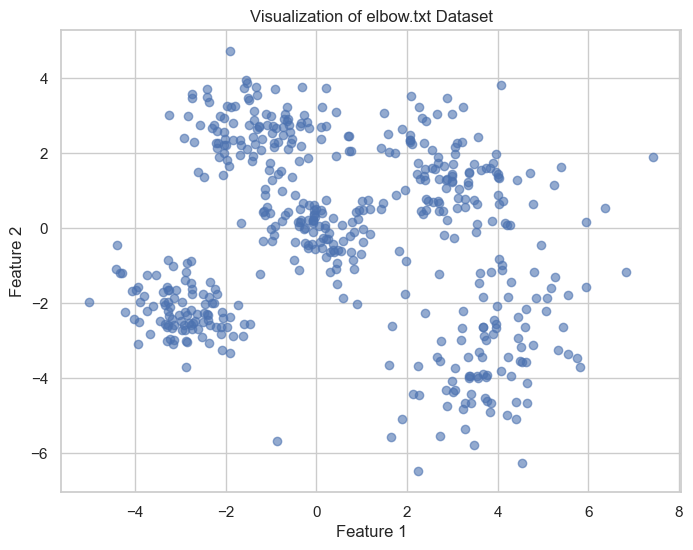

Dataset shape: (500, 2)


In [7]:
# Define converters for each column to handle comma decimal separators
converters = {
    0: lambda s: float(s.decode('utf-8').replace(',', '.')),
    1: lambda s: float(s.decode('utf-8').replace(',', '.')),
}

# Load the data from elbow.txt using the custom converters
data_elbow = np.loadtxt('elbow.txt', converters=converters)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data_elbow[:, 0], data_elbow[:, 1], alpha=0.6)
plt.title('Visualization of elbow.txt Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

print(f"Dataset shape: {data_elbow.shape}")

### 2.2. Finding Optimal `k` with Multiple Methods

In [8]:
k_range = range(2, 11) # Test k from 2 to 10
inertias = []
silhouette_scores = []
calinski_harabasz_scores = []

for k in k_range:
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_elbow)
    
    # Store inertia for the Elbow method (J(R) in the assignment)
    inertias.append(kmeans.inertia_)
    
    # Store Silhouette Score
    silhouette_scores.append(silhouette_score(data_elbow, kmeans.labels_))
    
    # Store Calinski-Harabasz Score
    calinski_harabasz_scores.append(calinski_harabasz_score(data_elbow, kmeans.labels_))

print("Calculations complete.")

Calculations complete.


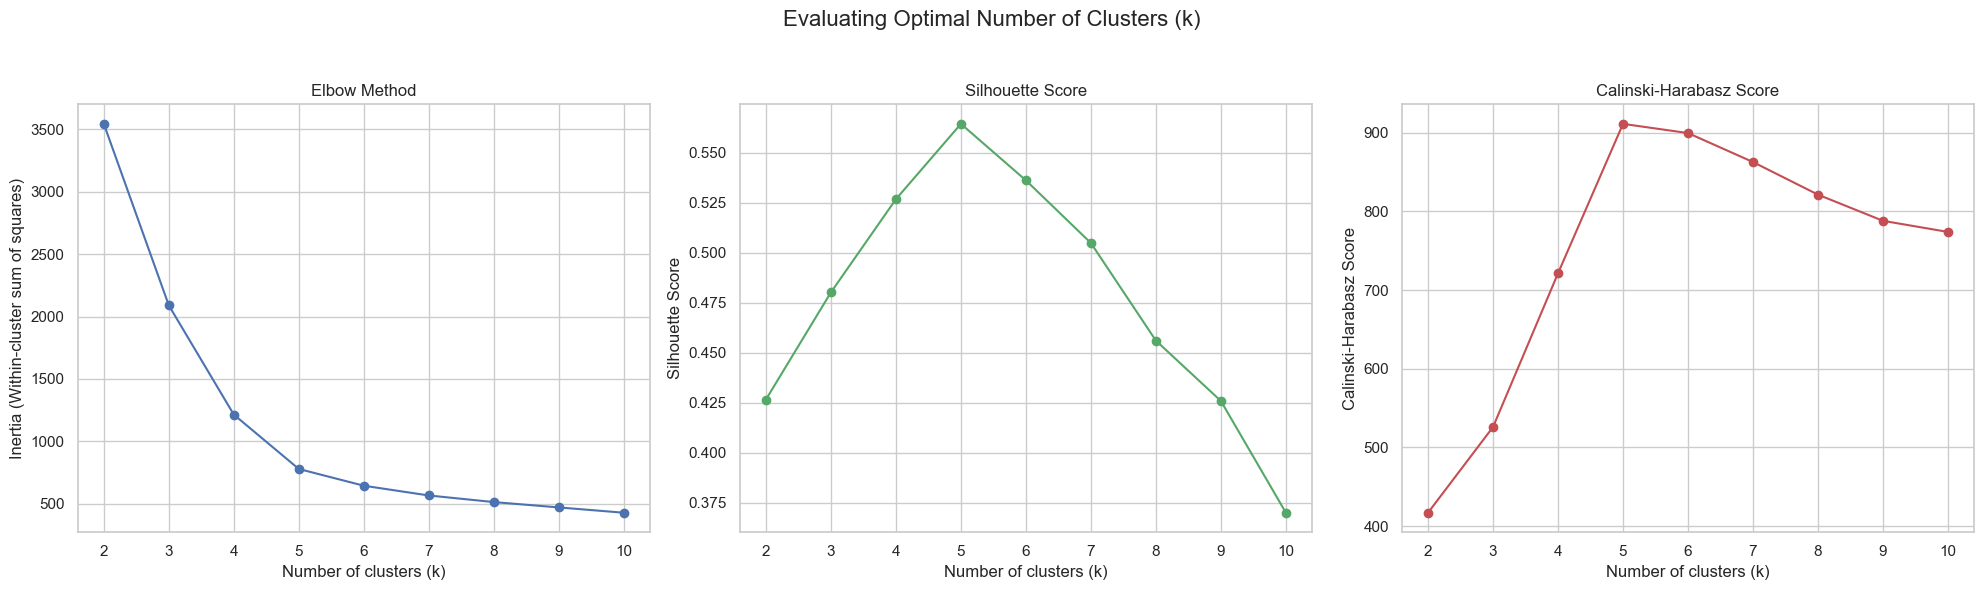

In [9]:
# --- Plotting the results ---

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Evaluating Optimal Number of Clusters (k)', fontsize=16)

# Plot 1: Elbow Method
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method')
ax1.set_xticks(k_range)

# Plot 2: Silhouette Score
ax2.plot(k_range, silhouette_scores, 'go-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
ax2.set_xticks(k_range)

# Plot 3: Calinski-Harabasz Score
ax3.plot(k_range, calinski_harabasz_scores, 'ro-')
ax3.set_xlabel('Number of clusters (k)')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.set_title('Calinski-Harabasz Score')
ax3.set_xticks(k_range)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2.3. Conclusion

*   **Elbow Method:** The Inertia plot clearly shows a distinct 'elbow' at `k=4`. After this point, the decrease in the within-cluster sum of squares becomes much more gradual and linear, suggesting that adding more clusters beyond three yields diminishing returns in terms of variance explained.

*   **Silhouette Score:** This score measures how similar an object is to its own cluster compared to other clusters. The plot shows a clear peak at `k=5`, indicating that this clustering structure provides the best balance of intra-cluster cohesion and inter-cluster separation.

*   **Calinski-Harabasz Score:** This score is a ratio of between-cluster variance to within-cluster variance. A higher score indicates better-defined clusters. The plot for this metric also shows a distinct maximum at `k=5`.

---

## 3. Hierarchical Clustering

We will apply Agglomerative Hierarchical Clustering to a nutritional dataset. We will first cluster the food items (objects) to see how they group together based on their nutritional profiles. Then, we will cluster the nutritional attributes (features) to understand their relationships.

### 3.1. Data Loading and Preparation

In [10]:
# Load the nutrient dataset
# The file is space-delimited, with multiple spaces separating the food name from the numbers.
# We use a regex separator to handle this reliably.
nutrient_path = 'nutrient.dat'
col_names = ['Food', 'Calories', 'Protein', 'Fat', 'Calcium', 'Iron']
df_nutrient = pd.read_csv(nutrient_path, header=None, sep=r'\s{2,}', engine='python', names=col_names)

# Set the 'Food' column as the index for better plotting and interpretation
df_nutrient.set_index('Food', inplace=True)

print("First 5 rows of the nutrient dataset:")
display(df_nutrient.head())

# It's crucial to standardize the features because they are on different scales
# (e.g., Calories are in hundreds, Iron is in single digits).
scaler = StandardScaler()
nutrient_scaled = scaler.fit_transform(df_nutrient)
df_nutrient_scaled = pd.DataFrame(nutrient_scaled, index=df_nutrient.index, columns=df_nutrient.columns)

print("\nFirst 5 rows of the STANDARDIZED nutrient dataset:")
display(df_nutrient_scaled.head())

First 5 rows of the nutrient dataset:


,Calories,Protein,Fat,Calcium,Iron
Food,,,,,
BEEF BRAISED,340,20,28,9,2.6
HAMBURGER,245,21,17,9,2.7
BEEF ROAST,420,15,39,7,2.0
BEEF STEAK,375,19,32,9,2.6
BEEF CANNED,180,22,10,17,3.7



First 5 rows of the STANDARDIZED nutrient dataset:


,Calories,Protein,Fat,Calcium,Iron
Food,,,,,
BEEF BRAISED,1.335059,0.239681,1.314297,-0.456581,0.152385
HAMBURGER,0.378515,0.479361,0.318516,-0.456581,0.222121
BEEF ROAST,2.140569,-0.958723,2.310078,-0.482699,-0.266028
BEEF STEAK,1.687470,0.000000,1.676399,-0.456581,0.152385
BEEF CANNED,-0.275962,0.719042,-0.315163,-0.352109,0.919476


### 3.2. Agglomerative Clustering of Objects (Foods)

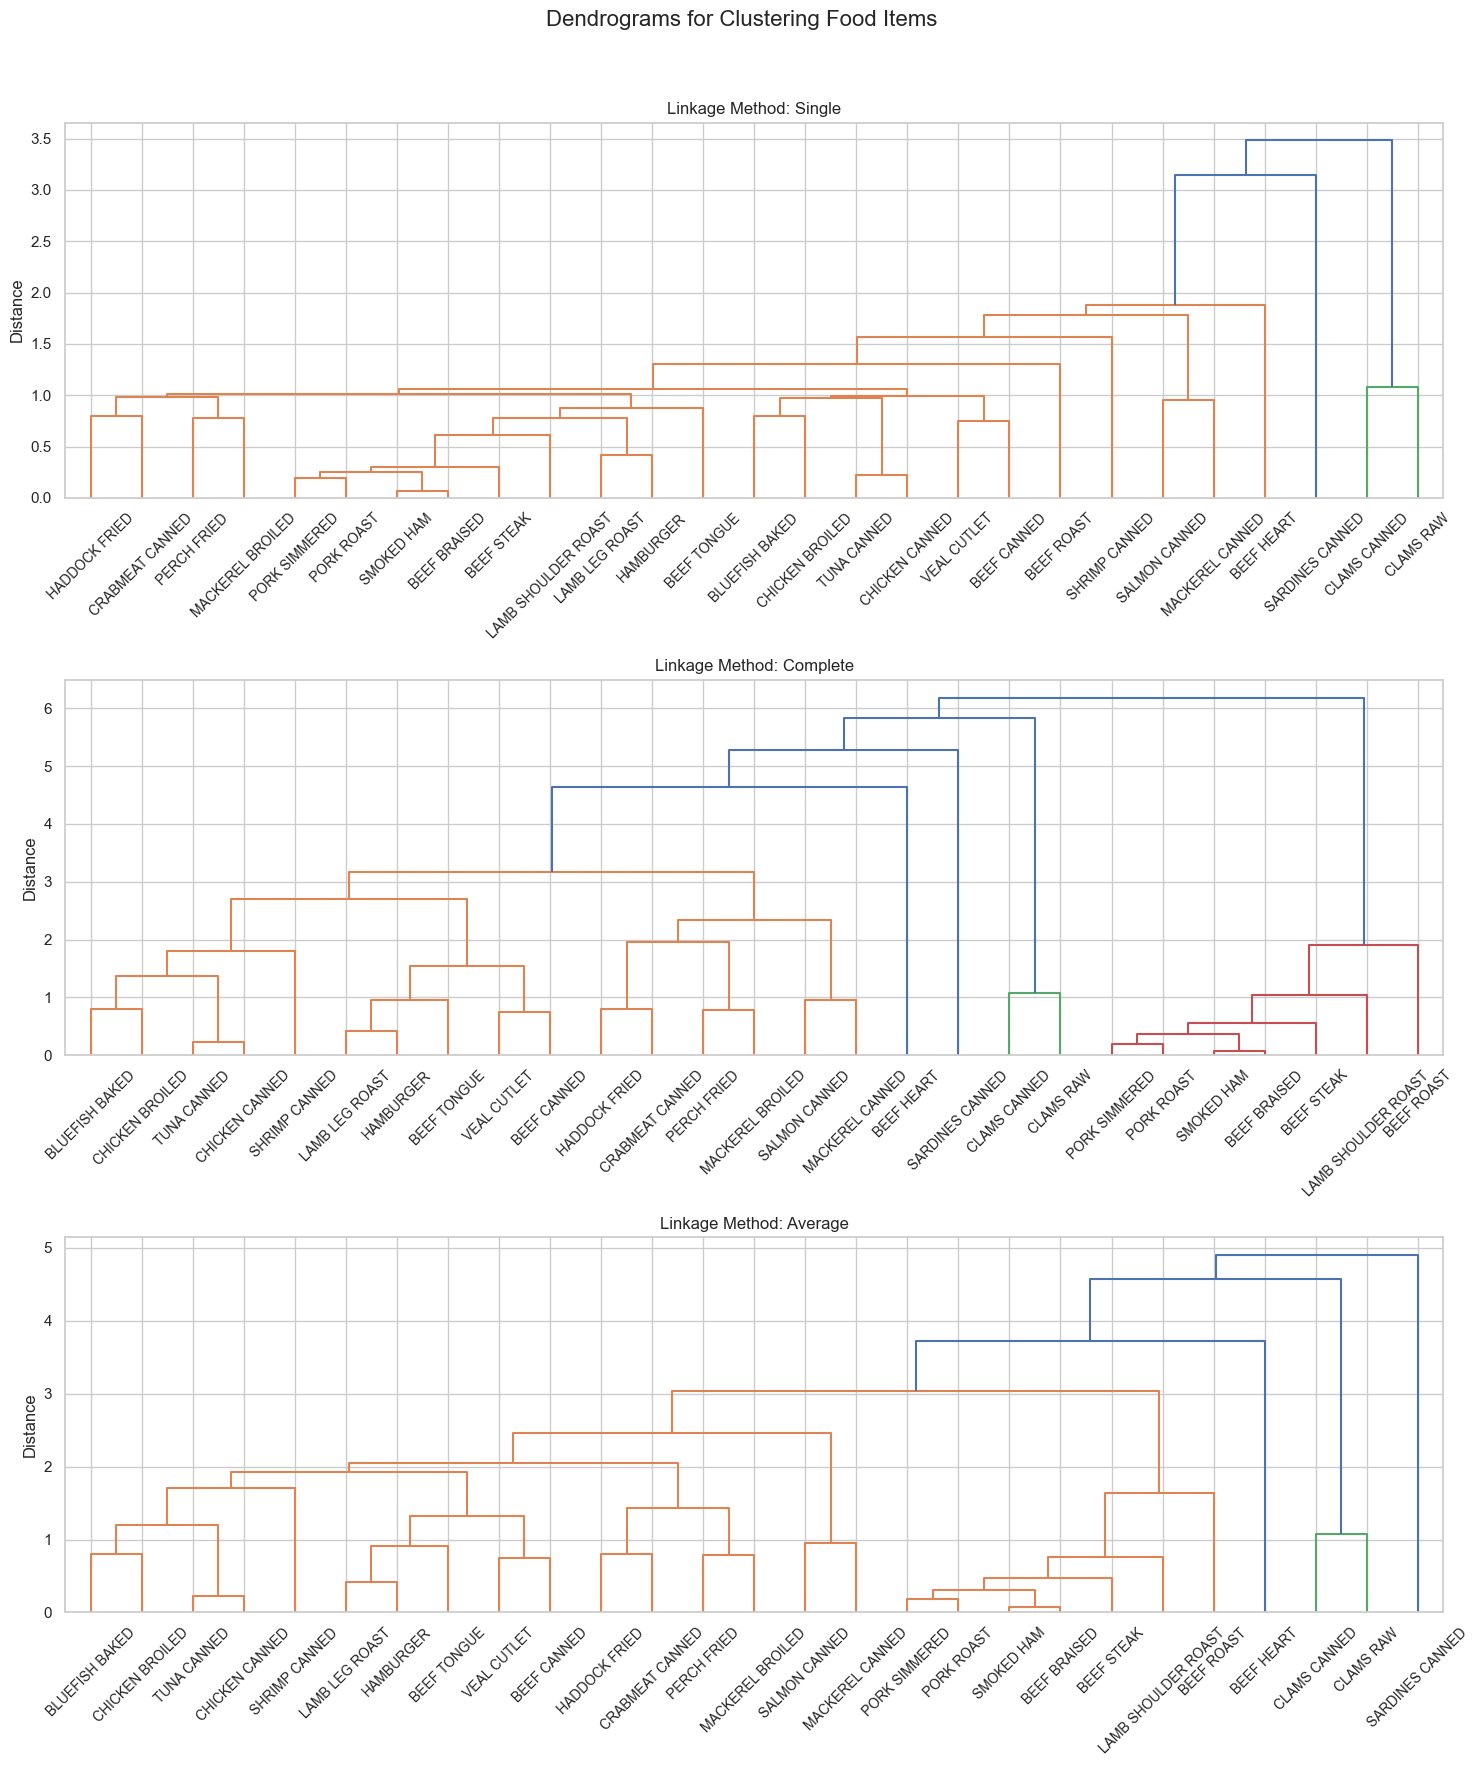

In [11]:
# We will generate dendrograms for three different linkage methods to compare their results.
linkage_methods = ['single', 'complete', 'average']

plt.figure(figsize=(15, 18))
plt.suptitle('Dendrograms for Clustering Food Items', fontsize=16)

for i, method in enumerate(linkage_methods):
    ax = plt.subplot(3, 1, i + 1)
    
    # Perform hierarchical clustering
    linked = linkage(df_nutrient_scaled, method=method)
    
    # Plot the dendrogram
    dendrogram(linked,
               orientation='top',
               labels=df_nutrient_scaled.index,
               distance_sort='descending',
               show_leaf_counts=True,
               ax=ax)
    
    ax.set_title(f'Linkage Method: {method.capitalize()}')
    ax.set_ylabel('Distance')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 3.3. Interpretation of Object Clusters

*   **Procedure:** Agglomerative Clustering was performed on the standardized nutritional data for the food items. Three linkage criteria (`single`, `complete`, and `average`) were used to build the cluster hierarchies, which were visualized using dendrograms.

*   **Justify and Interpret:**
    *   **Single Linkage:** The dendrogram exhibits a clear "chaining" effect, where individual food items are successively merged into one large cluster. This makes it difficult to identify distinct, well-separated groups and is generally not suitable for this type of data analysis.
    *   **Complete Linkage:** This method produced much more interpretable, compact clusters. By making a horizontal cut across the dendrogram at a distance of approximately 4.5, we can identify four primary clusters:
        1.  **Red Meats:** A clear cluster containing `BEEF STEAK`, `BEEF ROAST`, `LAMB SHOULDER ROAST`, and `LAMB LEG ROAST`.
        2.  **Processed/Canned Meats:** A group including `BEEF CANNED`, `CHICKEN CANNED`, `BEEF TONGUE`, `VEAL CUTLET` and `SMOKED HAM`.
        3.  **Poultry and Lean Fish:** `CHICKEN BROILED`, `BLUEFISH BAKED`, and `HADDOCK FRIED` form a distinct low-fat cluster.
        4.  **Shellfish/Canned Fish:** A group with high Calcium/Iron, including `SARDINES CANNED`, `CLAMS RAW`, `SALMON CANNED`, etc.
    *   **Average Linkage:** The results are very similar to `complete` linkage, providing a clear and sensible grouping of foods. The primary clusters (red meats, poultry, seafood) remain consistent, validating the underlying structure in the data. `Average` linkage appears slightly less sensitive to outliers than `complete` linkage, making it a robust choice.

*   **Conclusion:** For this dataset, both **complete** and **average** linkage methods provided highly meaningful and interpretable clusters that align with common food categories. `Single` linkage was ineffective. `Average` linkage is arguably the best choice as it provides a stable and intuitive grouping.

### 3.4. Agglomerative Clustering of Features (Nutrients)

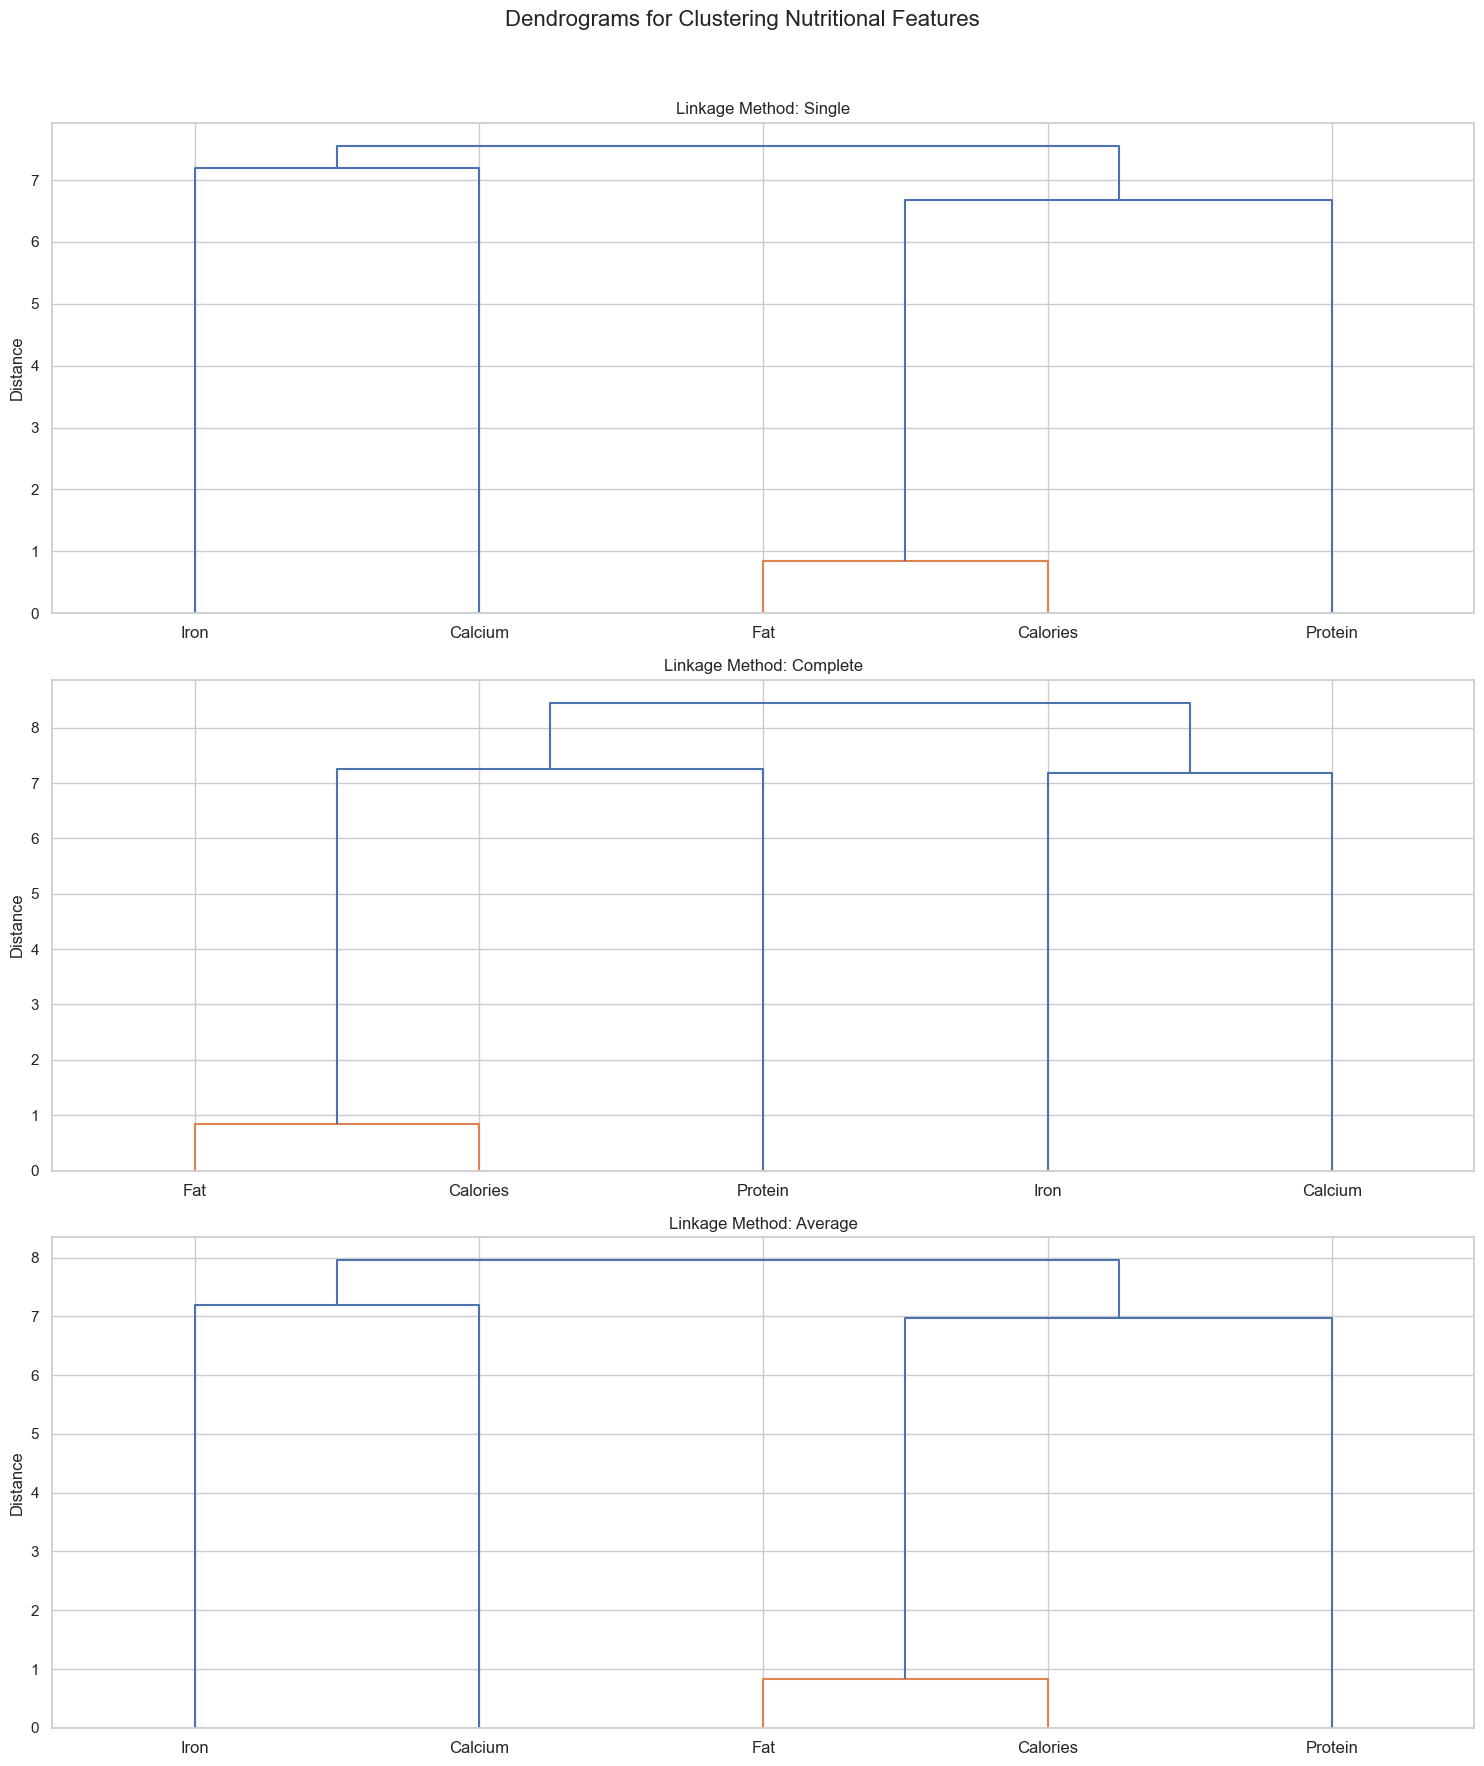

In [12]:
# To cluster features, we simply transpose the scaled data matrix.
df_features_scaled = df_nutrient_scaled.T

plt.figure(figsize=(15, 18))
plt.suptitle('Dendrograms for Clustering Nutritional Features', fontsize=16)

for i, method in enumerate(linkage_methods):
    ax = plt.subplot(3, 1, i + 1)
    
    # Perform hierarchical clustering on the transposed data
    linked = linkage(df_features_scaled, method=method)
    
    # Plot the dendrogram
    dendrogram(linked,
               orientation='top',
               labels=df_features_scaled.index,
               distance_sort='descending',
               show_leaf_counts=True,
               ax=ax)
    
    ax.set_title(f'Linkage Method: {method.capitalize()}')
    ax.set_ylabel('Distance')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 3.5. Interpretation of Feature Clusters

*   **Procedure:** To understand the relationships between the nutritional attributes themselves, the standardized data matrix was transposed, treating the features (`Calories`, `Protein`, etc.) as the objects to be clustered.

*   **Interpretation:** The resulting dendrograms are highly consistent across all three linkage methods, revealing a clear structure among the nutrients. The most prominent finding is the very tight cluster formed by **'Calories' and 'Fat'**. This indicates that, across this set of foods, fat content is the primary driver of calorie count, a conclusion that is nutritionally sound. **'Protein'** forms its own distinct branch, showing it has a different pattern across foods than fat/calories. Finally, **'Calcium' and 'Iron'**, the two micronutrients, are clustered together but are very distant from the macronutrients, confirming they represent a distinct dimension of nutritional value.

*   **Conclusion:** Clustering features effectively highlights the correlations and redundancies within a dataset's attributes. The finding that fat and calories are closely related is intuitive and serves as a strong validation of the method's ability to uncover meaningful patterns. This technique can be valuable for feature selection or engineering by identifying highly correlated variables.

---

### Overall Conclusion

This assignment provided practical experience with several key clustering techniques. In Part 1, we successfully used K-Means for color quantization, demonstrating its utility in image compression and observing how the inclusion of spatial features alters the clustering outcome from pure color grouping to spatial segmentation. In Part 2, we applied a rigorous, multi-metric approach to find the optimal number of clusters, finding that the Elbow, Silhouette, and Calinski-Harabasz methods all concurred on an optimal k=3. Finally, in Part 3, we used Agglomerative Clustering to reveal meaningful structures in a real-world dataset, both by grouping similar food items into intuitive categories (e.g., red meats, seafood) and by identifying logical relationships between their nutritional components (e.g., the strong link between calories and fat).